In [1]:
import pandas as pd
import numpy as np
import tcrdist
import tcrdist.repertoire

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels
import itertools
import scipy.stats

In [2]:
from IPython.display import display, HTML
display(HTML("""
<style>
.lm-Widget {overflow-x: scroll !important;}
</style>
"""))

In [3]:
%config InlineBackend.figure_format = "retina"

In [8]:
pd.options.display.max_columns = 200

## CD8

In [4]:
df = pd.read_csv('../analysis/post_gliph_filter_nik.csv', index_col=0)

In [5]:
df = df.drop_duplicates().rename({
    'TcRb': 'cdr3_b_aa',
    'V': 'v_b_gene',
    'J': 'j_b_gene'
}, axis='columns')

In [6]:
df['count'] = 1

In [7]:
df.v_b_gene += '*01'
df.j_b_gene += '*01'

In [ ]:
tr = tcrdist.repertoire.TCRrep(
    organism='human',
    chains=['beta'],
    db_file='alphabeta_gammadelta_db.tsv',
    cell_df=df,
    store_all_cdr=False
)

In [9]:
olga_beta  = tcrdist.pgen.OlgaModel(chain_folder="human_T_beta", recomb_type="VDJ")

tr.clone_df['pgen_cdr3_b_aa'] = olga_beta.compute_aa_cdr3_pgens(
    CDR3_seq=tr.clone_df.cdr3_b_aa
)

In [10]:
tr.clone_df['pgen_log10'] = tr.clone_df.pgen_cdr3_b_aa.copy()
min_nonzero_pgen = tr.clone_df.pgen_log10[tr.clone_df.pgen_log10.gt(0)].min()
tr.clone_df.loc[tr.clone_df.pgen_log10.eq(0), 'pgen_log10'] = min_nonzero_pgen * 0.001

Text(0.5, 0, '$-log_{10}(Pgen)$')

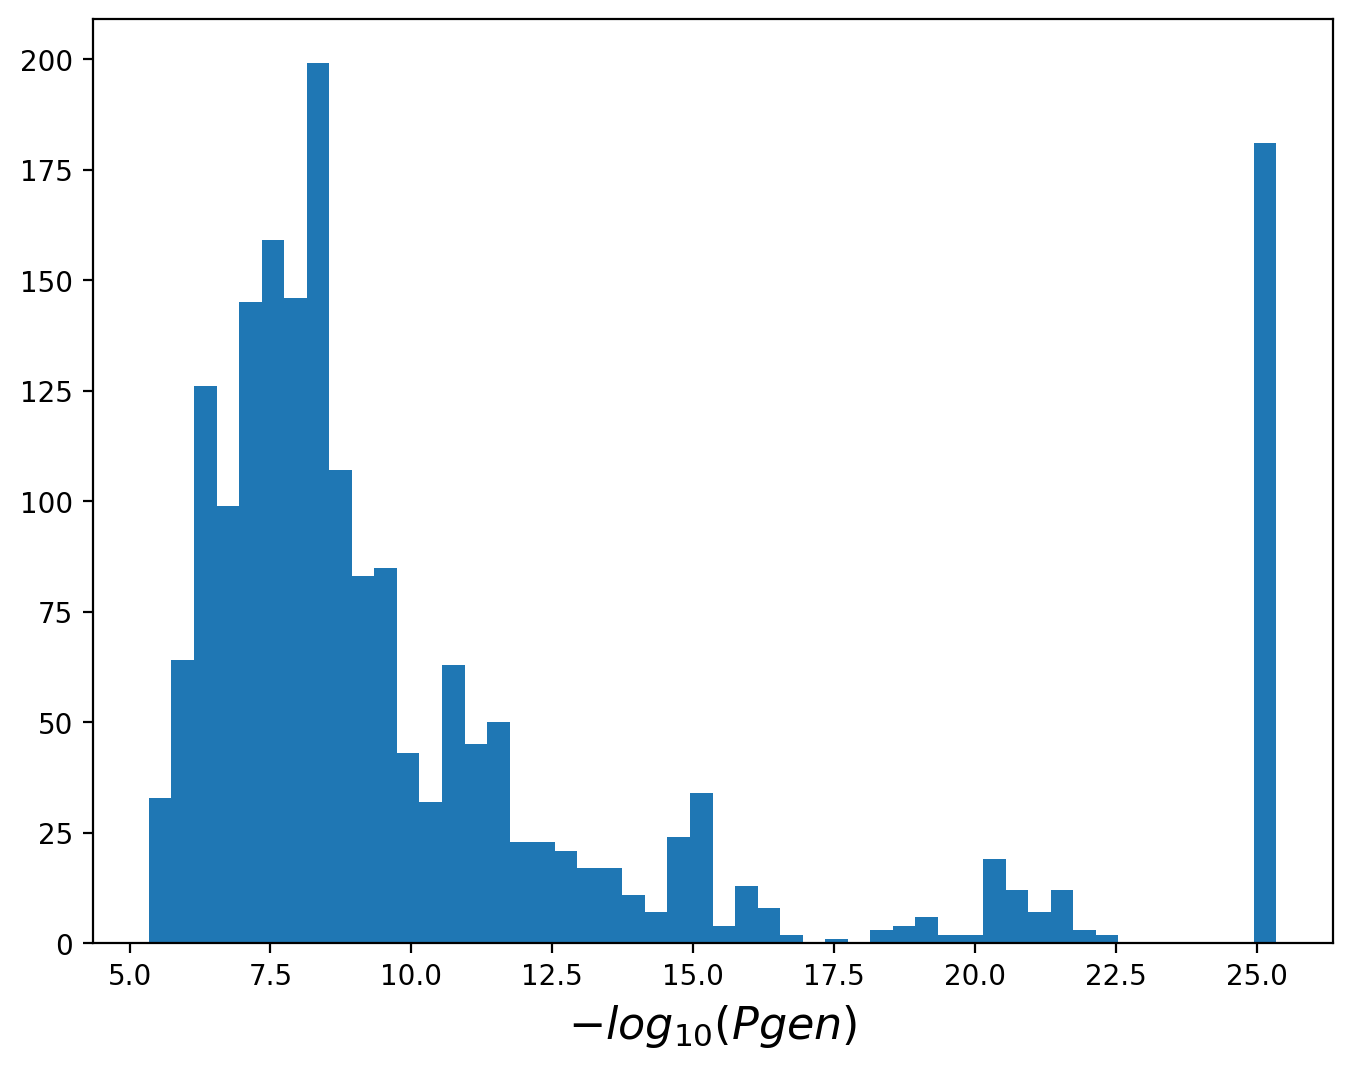

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(-np.log10(tr.clone_df.pgen_log10), bins=50);
ax.set_xlabel('$-log_{10}(Pgen)$', size=16)

In [12]:
tr.clone_df[['study_id', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene']].duplicated().sum()

571

In [13]:
olga_beta.compute_aa_cdr3_pgens(
    CDR3_seq=['CASSGDFYNEQFY'],
    V_usage_mask_in=['TRBV27*01'],
    J_usage_mask_in=['TRBJ2-1*01']
)

[0.0]

In [14]:
cross_epitopes = pd.read_csv('../analysis/mira_postgliph_epitopes_df_cd8.csv', index_col=0)

<Axes: ylabel='Frequency'>

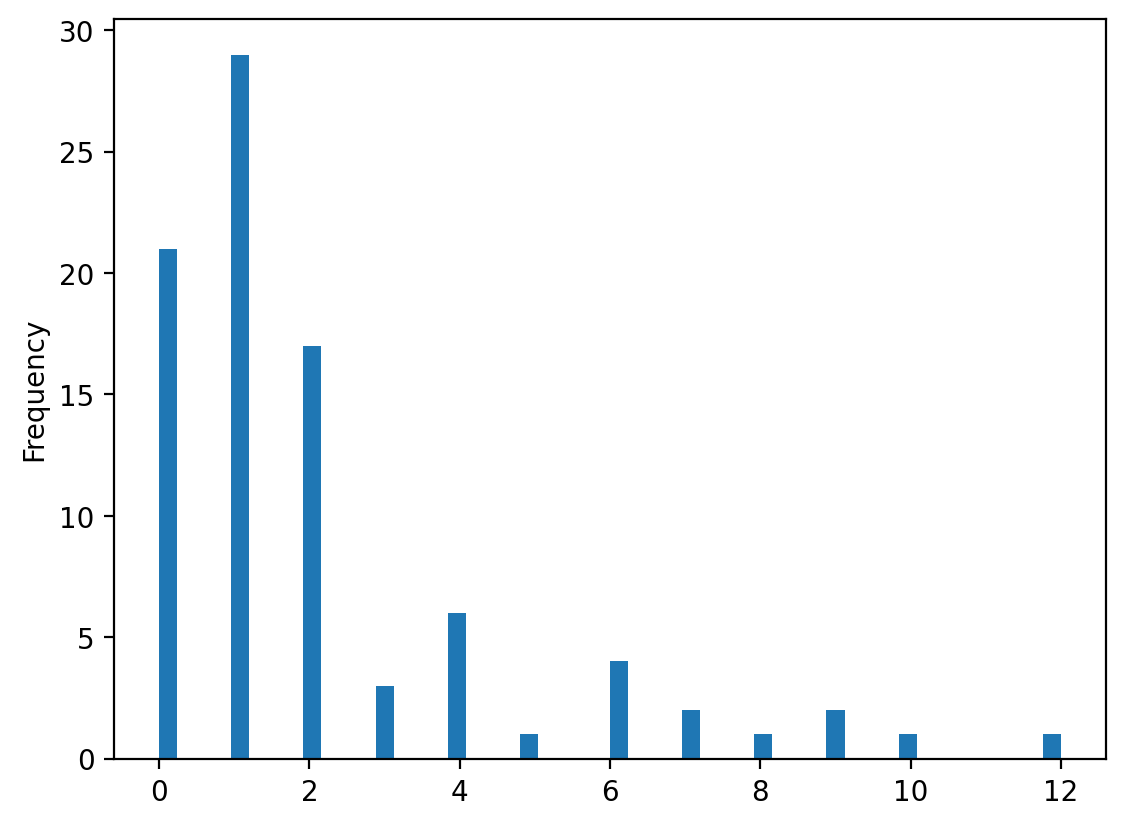

In [15]:
cross_epitopes.sort_values('n_noncovid_pts').n_noncovid_pts.plot.hist(bins=50)

In [16]:
clones = tr.clone_df.copy()

In [17]:
clones.pgen_log10 = np.log10(clones.pgen_log10)

In [18]:
clones.to_csv('../analysis/post_gliph_filter_nik_with_pgen.csv')

In [ ]:
clones

In [20]:
clones.shape

(1937, 17)

In [21]:
HUE_ORDER = ['Non-pneumonia control', 'Other pneumonia', 'Other viral pneumonia', 'COVID-19']

## Check n_noncovid_pts >= 1

In [22]:
mira = pd.read_csv('../analysis/mira_postgliph_2_Nik.csv', index_col=0)

In [23]:
mira.shape

(1095, 11)

In [24]:
mira = mira.merge(
    tr.clone_df[['study_id', 'cdr3_b_aa', 'pgen_log10']].drop_duplicates(),
    left_on=['study_id', 'TCR'],
    right_on=['study_id', 'cdr3_b_aa']
)

In [25]:
mira.pna_type_verified = pd.Categorical(mira.pna_type_verified, categories=HUE_ORDER)

In [26]:
mira['Epitope'] = mira.Amino_Acids.str.split(',').str[0]

In [27]:
mira.pgen_log10 = np.log10(mira.pgen_log10)

In [28]:
mira.loc[mira.Amino_Acids.str.contains(','), 'Epitope'] += '*'

In [29]:
epitopes_to_check = cross_epitopes.loc[cross_epitopes.n_noncovid_pts.ge(1)].Epitope

In [30]:
mira_epitopes = mira.loc[mira.Epitope.isin(epitopes_to_check)].copy()

In [31]:
mira_epitopes.Epitope.nunique()

67

In [32]:
epitopes_to_check.size

67

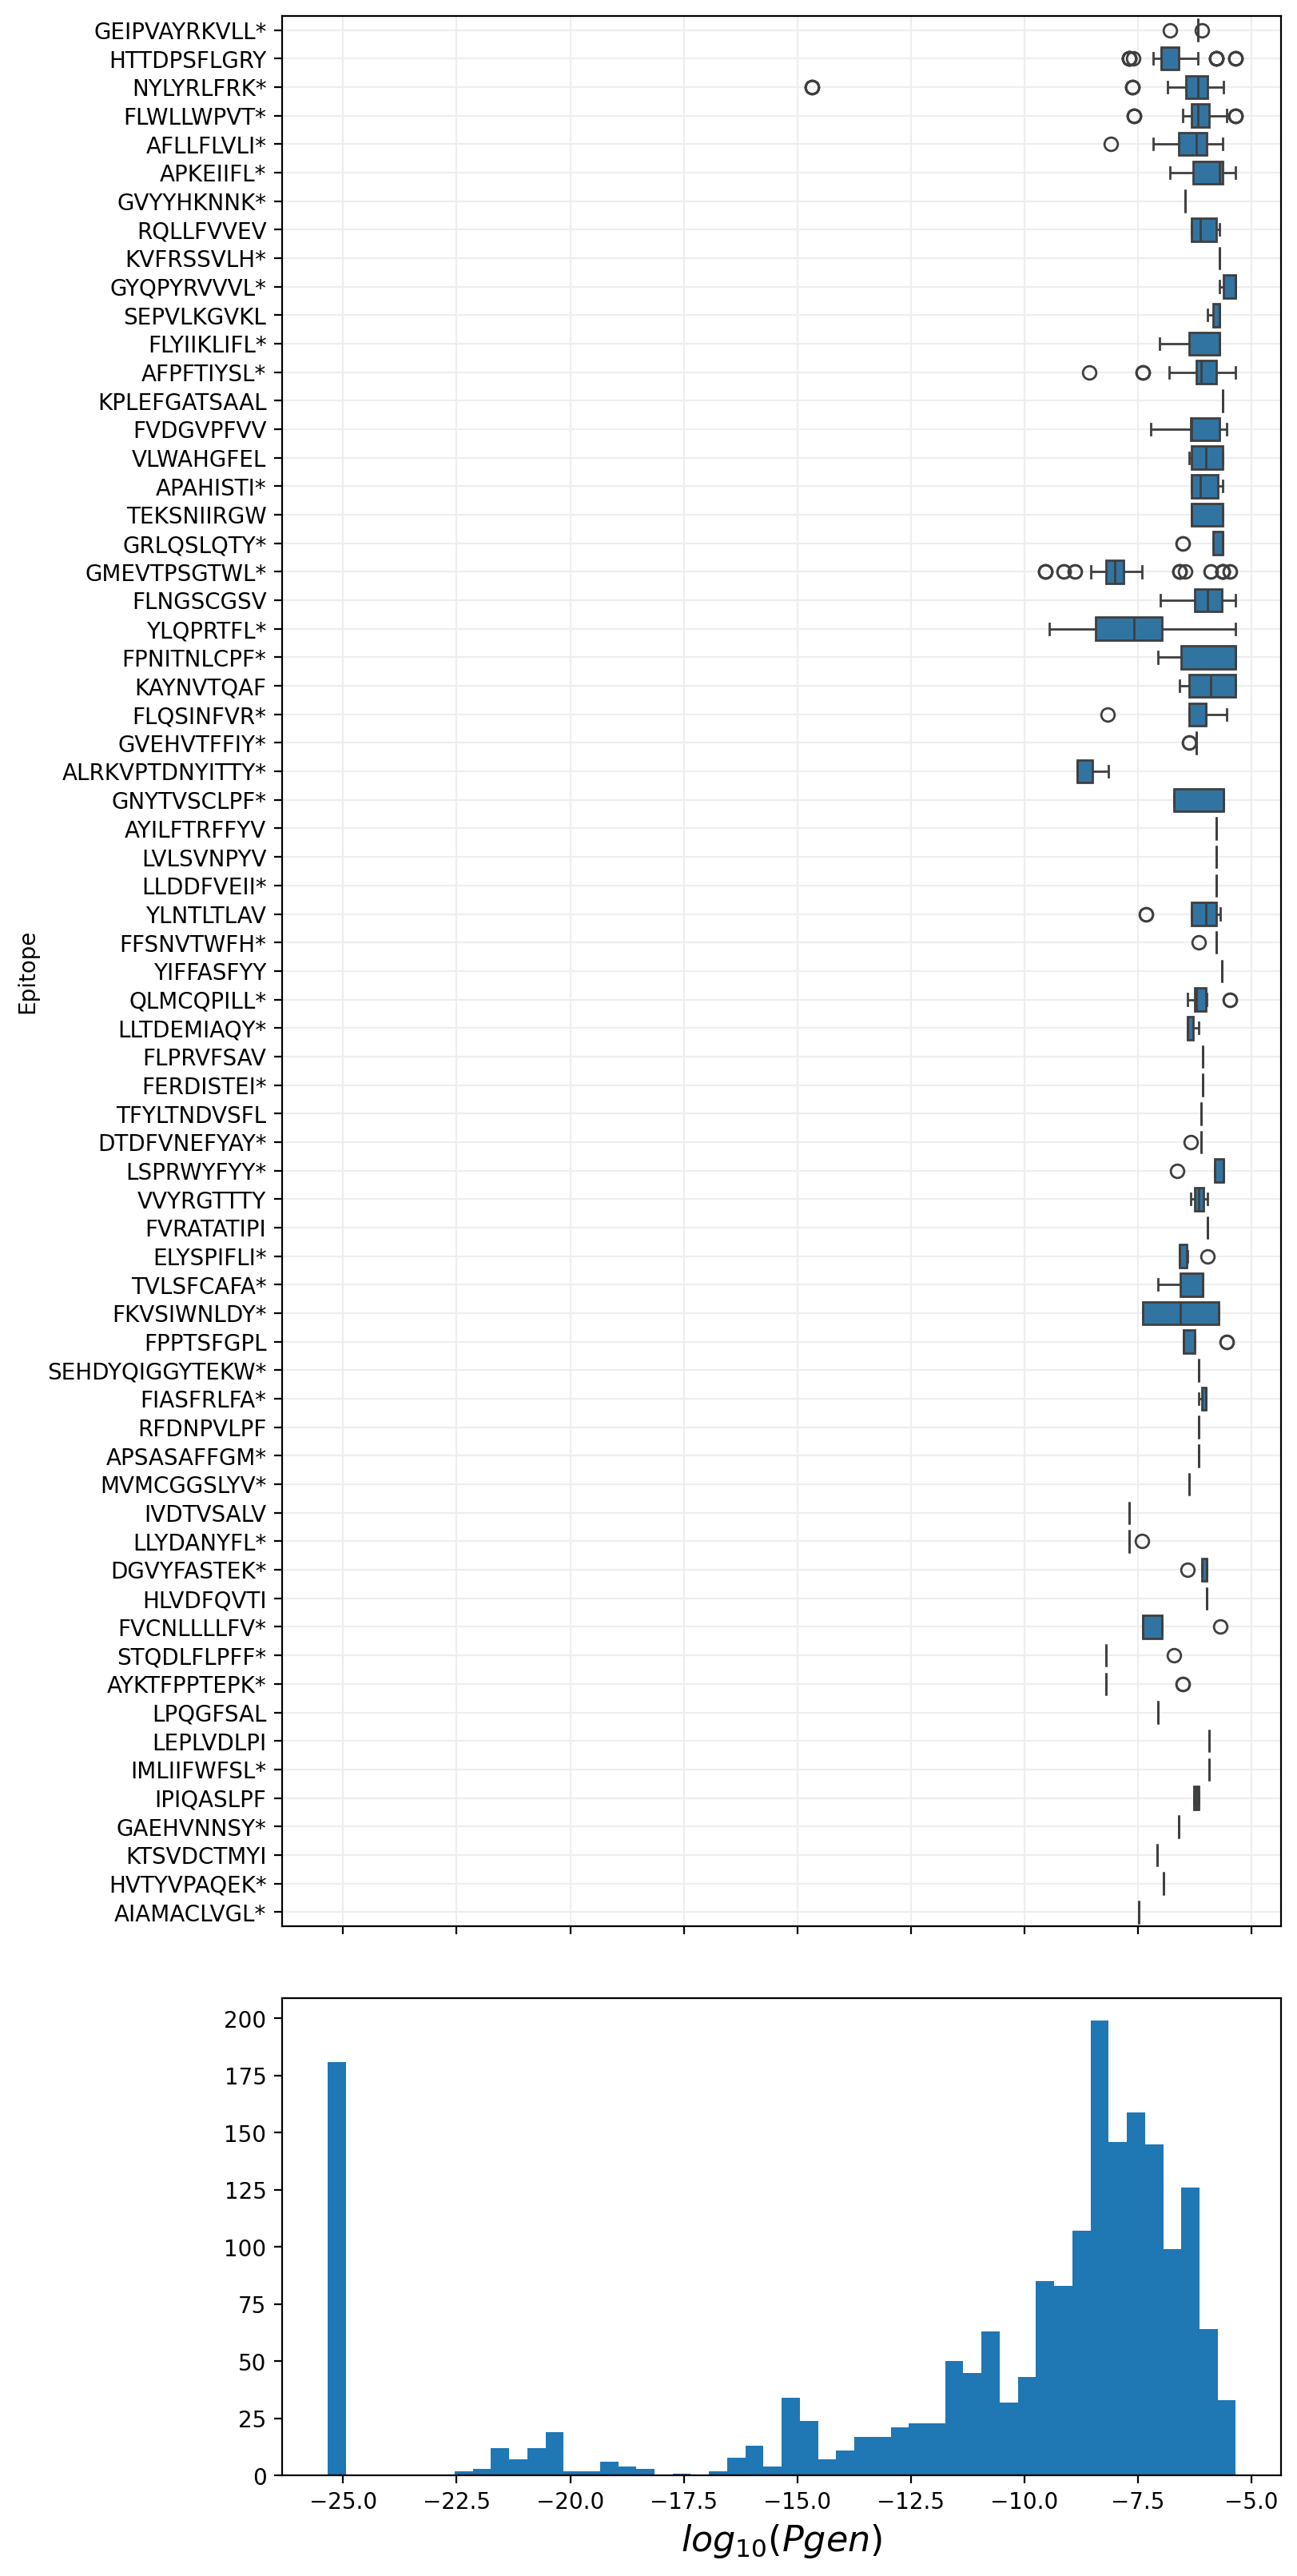

In [33]:
fig, axes = plt.subplots(
    figsize=(8, 16),
    nrows=2,
    sharex=True,
    gridspec_kw=dict(hspace=0.05, height_ratios=[0.8, 0.2]),
    constrained_layout=True
)
sns.boxplot(
    data=mira_epitopes,
    y='Epitope',
    x='pgen_log10',
    ax=axes[0]
)
axes[0].set_xlabel('$log_{10}(Pgen)$', size=16)
axes[1].hist(np.log10(tr.clone_df.pgen_log10), bins=50);
axes[1].set_xlabel('$log_{10}(Pgen)$', size=16)
axes[0].grid(color='#eee')
fig.savefig('01_crossreactive.png')

## Check n_noncovid_pts >= 3

In [34]:
epitopes_to_check = cross_epitopes.loc[cross_epitopes.n_noncovid_pts.ge(3)].Epitope

In [35]:
mira_epitopes = mira.loc[mira.Epitope.isin(epitopes_to_check)].copy()

In [36]:
mira_epitopes.Epitope.nunique()

21

In [37]:
epitopes_to_check.size

21

(-10.1, -5.0)

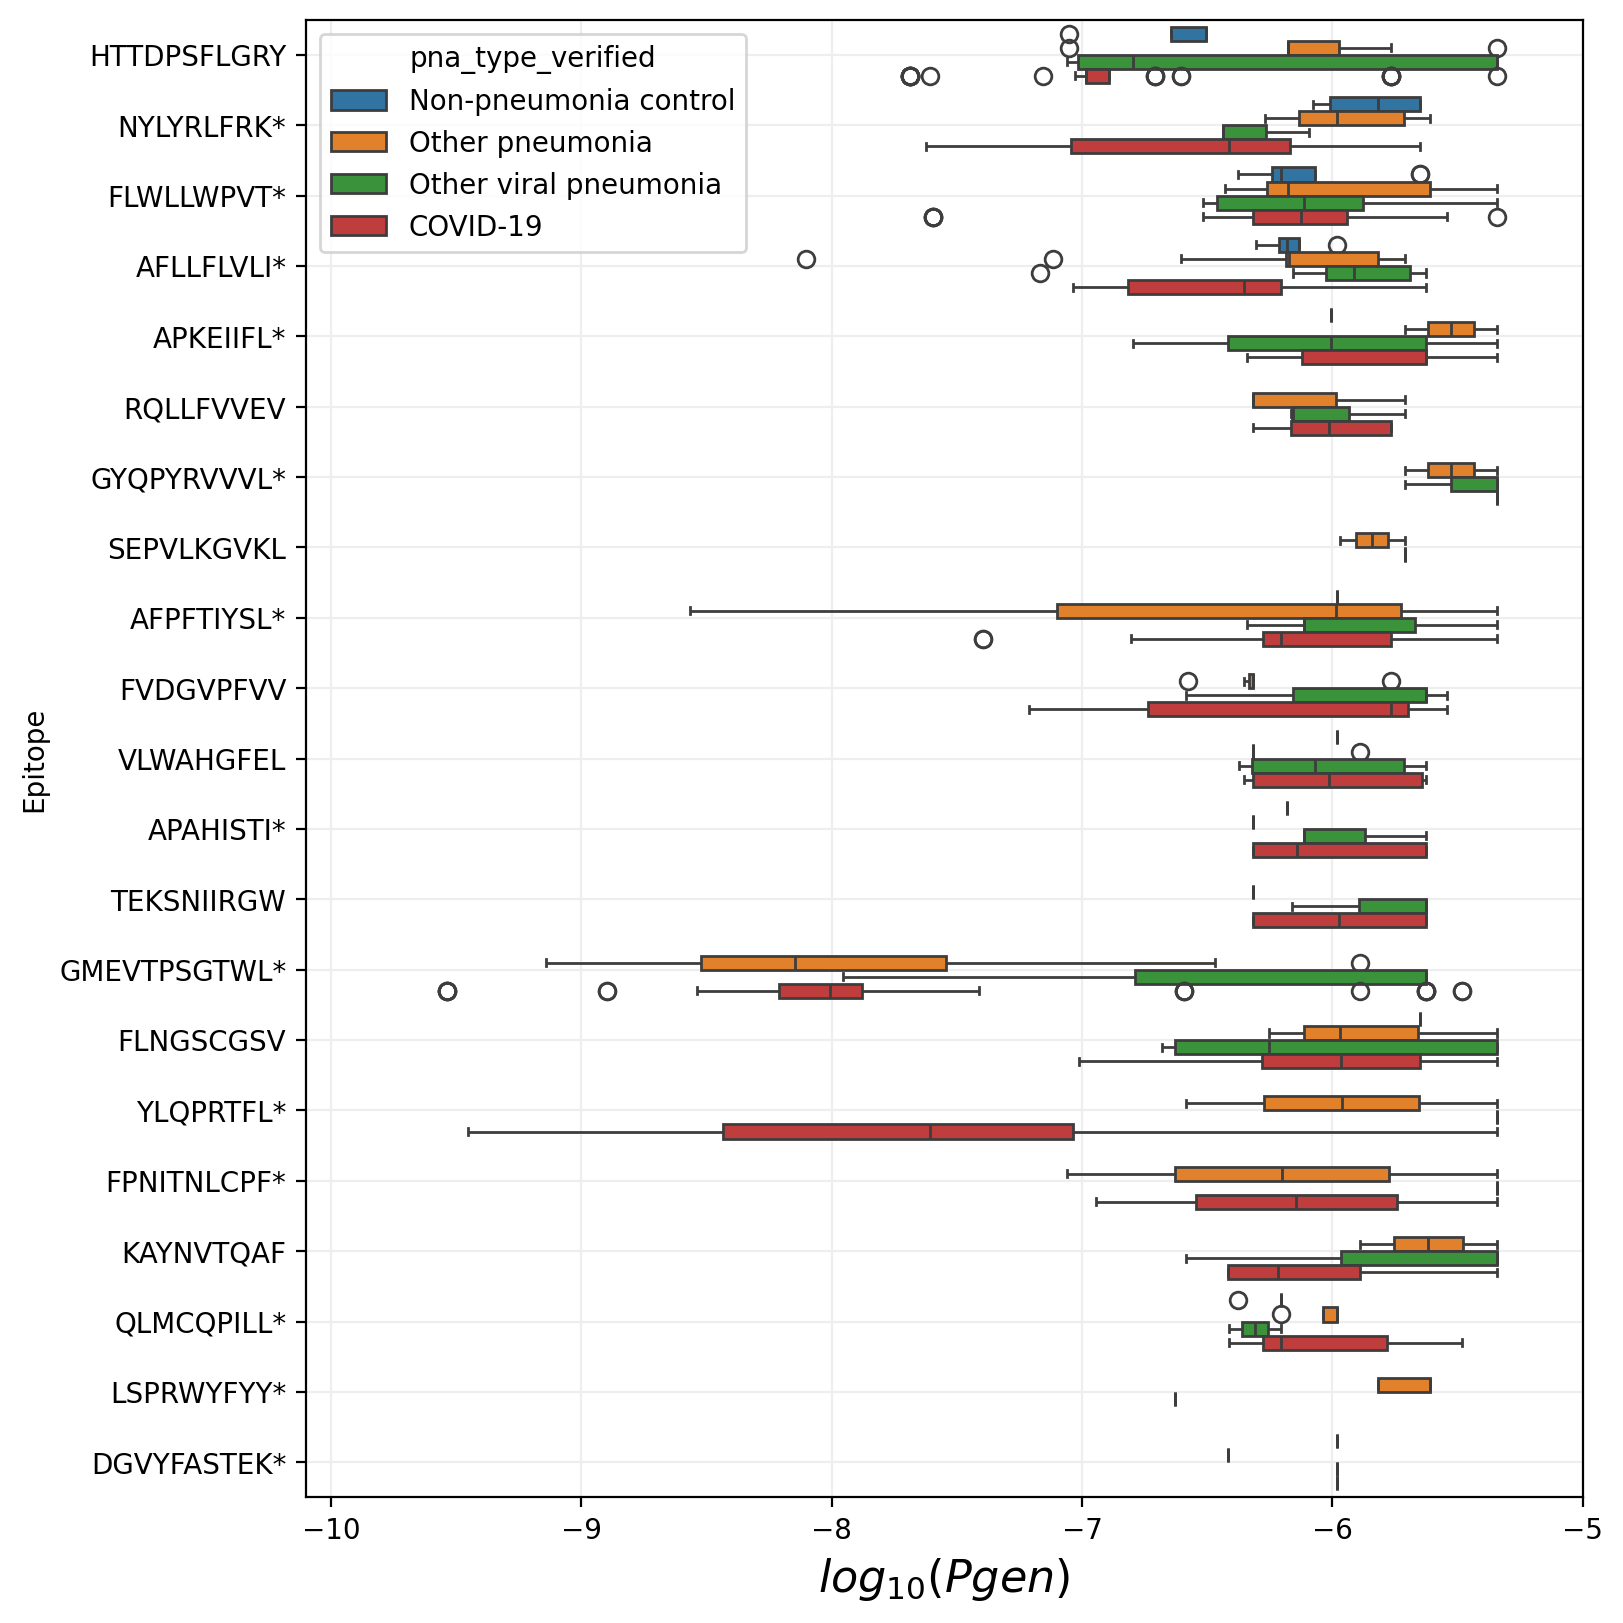

In [38]:
fig, ax = plt.subplots(
    figsize=(8, 8),
    constrained_layout=True
)
sns.boxplot(
    data=mira_epitopes,
    hue='pna_type_verified',
    y='Epitope',
    x='pgen_log10',
    ax=ax
)
# outlier = mira_epitopes.loc[mira_epitopes.pgen_log10.lt(-10)].copy()
# outlier.pgen_log10 = -10
# sns.scatterplot(
#     data=outlier,
#     hue='pna_type_verified',
#     y='Epitope',
#     x='pgen_log10',
#     markers=['<']
# )
ax.set_xlabel('$log_{10}(Pgen)$', size=16)
ax.grid(color='#eee')
ax.set_xlim(-10.1, -5)

Text(0.5, 0, '$log_{10}(Pgen)$')

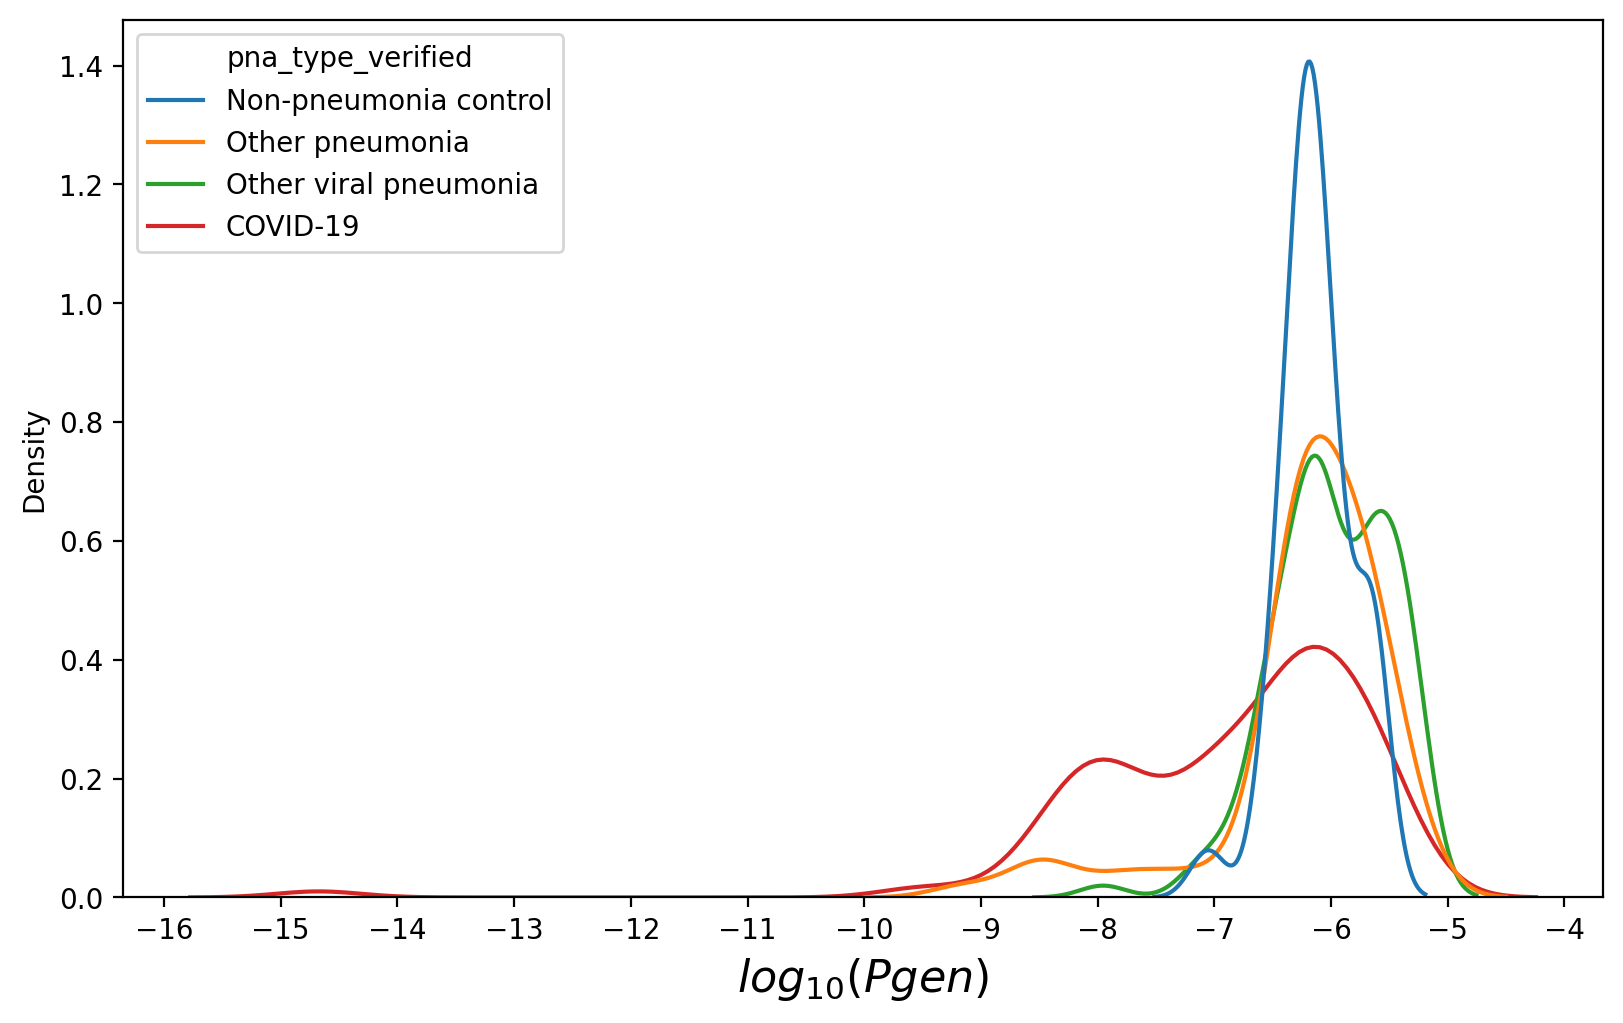

In [39]:
fig, ax = plt.subplots(
    figsize=(8, 5),
    constrained_layout=True
)
sns.kdeplot(
    data=mira_epitopes,
    hue='pna_type_verified',
    x='pgen_log10',
    ax=ax,
    common_norm=False
)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.set_xlabel('$log_{10}(Pgen)$', size=16)

# Overall comparison

In [40]:
stats_results = []
for d1, d2 in itertools.combinations(mira.pna_type_verified.unique(), 2):
    if d1 == d2:
        continue
    data1 = mira.pgen_log10[mira.pna_type_verified.eq(d1)]
    data2 = mira.pgen_log10[mira.pna_type_verified.eq(d2)]
    if data1.size == 0 or data2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(data1, data2).pvalue
    stats_results.append([d1, d2, data1.size, data2.size, pval])

stats_results = pd.DataFrame(
    stats_results,
    columns=["group1", "group2", "group1_size", "group2_size", "pval"]
)
stats_results['padj'] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval)[1]
stats_results_sign = stats_results.loc[stats_results.padj.lt(0.01)]

In [41]:
stats_results

,group1,group2,group1_size,group2_size,pval,padj
0,Other pneumonia,COVID-19,201,701,8.908175e-16,2.672452e-15
1,Other pneumonia,Other viral pneumonia,201,141,2.016711e-02,2.016711e-02
2,Other pneumonia,Non-pneumonia control,201,52,1.597349e-02,1.916818e-02
3,COVID-19,Other viral pneumonia,701,141,5.015707e-21,3.009424e-20
4,COVID-19,Non-pneumonia control,701,52,6.062589e-03,9.093884e-03
5,Other viral pneumonia,Non-pneumonia control,141,52,1.442656e-04,2.885311e-04


/tmp/ipykernel_268959/3103648086.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Text(0, 0.5, '')

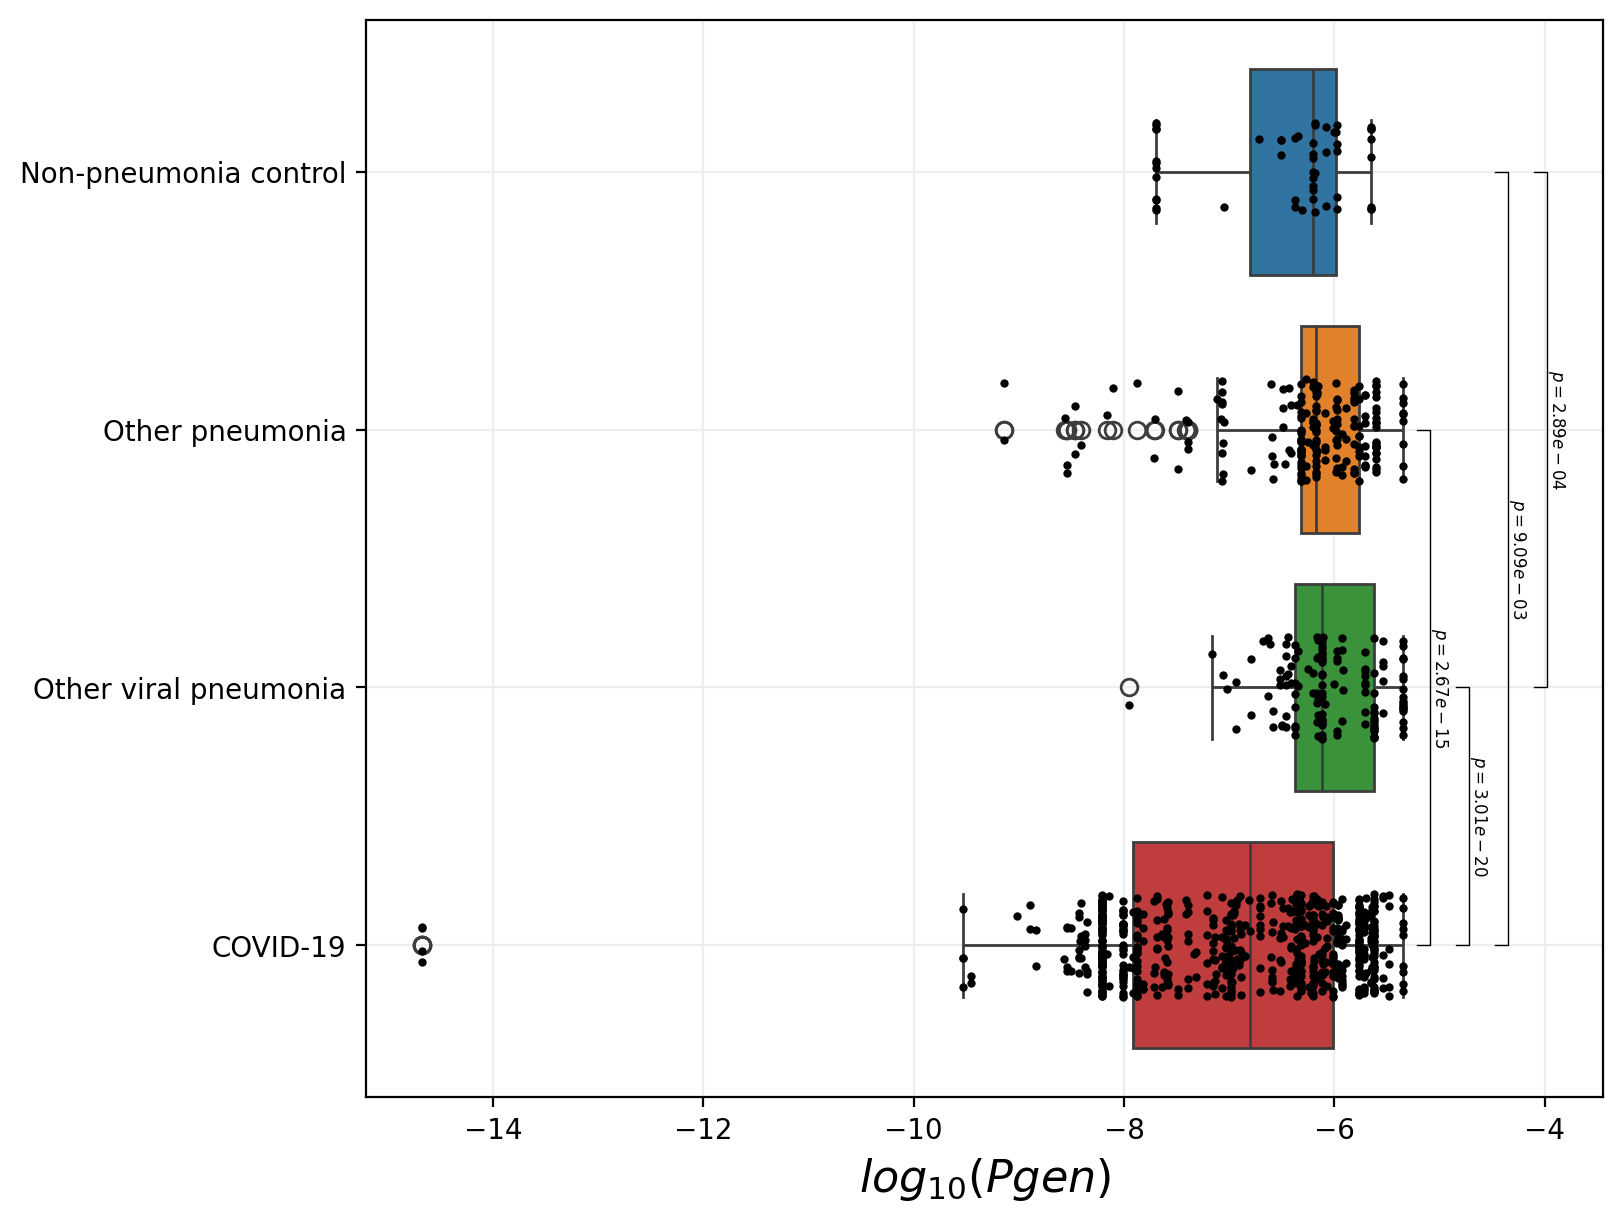

In [42]:
fig, ax = plt.subplots(
    figsize=(8, 6),
    constrained_layout=True
)
sns.boxplot(
    data=mira,
    y='pna_type_verified',
    x='pgen_log10',
    ax=ax,
    palette='tab10',
    legend=False
)
sns.stripplot(
    data=mira,
    y='pna_type_verified',
    x='pgen_log10',
    ax=ax,
    color='k',
    size=3,
    jitter=0.2,
    legend=False
)
ax.set_xlabel('$log_{10}(Pgen)$', size=16)
ax.grid(color='#eee')
start_height = mira.pgen_log10.max()
incrementer = 15 # px
labels = [x.get_text() for x in ax.get_yticklabels()]
q = ax.transData.inverted().transform([[0, 0], [incrementer, 0]])
x_offset = q[1][0] - q[0][0]
gap = x_offset / 2
x = start_height
for _, r in stats_results_sign.iterrows():
    p = f'$p={r.padj:.2e}$'

    # statistical annotation
    try:
        y1, y2 = labels.index(str(r.group1)), labels.index(str(r.group2))
    except:
        if type(r.group1) == float:
            group1 = int(r.group1)
        if type(r.group1) == float:
            group2 = int(r.group1)
        y1, y2 = labels.index(str(group1)), labels.index(str(group2))
    col = 'k'
    h = gap
    x += gap

    bracket = ax.plot([x, x + h, x + h, x], [y1, y1, y2, y2], lw=0.5, c=col)
    txt = ax.text(x + 0.95 * h, (y1 + y2) * 0.5, p, ha='left', va='center', color=col, size=6, rotation=-90)
    x += x_offset
# ax.set_xlim(-10.1, -5)
ax.set_ylabel('')

In [43]:
mira.loc[mira.pgen_log10.lt(-14)]

,TCR,ORF_Coverage,Amino_Acids,pattern,V,J,Sample,study_id,tc_pt_study_id,pna_type_verified,Outcome,cdr3_b_aa,pgen_log10,Epitope
820,CASSESGGYEQYV,surface glycoprotein,"NYLYRLFRK,NYNYLYRLF",SE%GGYE,TRBV2,TRBJ2-7,TCR_36.clonotypes.ALL,1298,1298-BAL-00,COVID-19,Discharged,CASSESGGYEQYV,-14.674446,NYLYRLFRK*
821,CASSESGGYEQYV,surface glycoprotein,"NYLYRLFRK,NYNYLYRLF",SE%GGYE,TRBV6-1,TRBJ2-7,TCR_36.clonotypes.ALL,1298,1298-BAL-00,COVID-19,Discharged,CASSESGGYEQYV,-14.674446,NYLYRLFRK*
822,CASSESGGYEQYV,surface glycoprotein,"NYLYRLFRK,NYNYLYRLF",SES%GYE,TRBV2,TRBJ2-7,TCR_36.clonotypes.ALL,1298,1298-BAL-00,COVID-19,Discharged,CASSESGGYEQYV,-14.674446,NYLYRLFRK*
823,CASSESGGYEQYV,surface glycoprotein,"NYLYRLFRK,NYNYLYRLF",SES%GYE,TRBV6-1,TRBJ2-7,TCR_36.clonotypes.ALL,1298,1298-BAL-00,COVID-19,Discharged,CASSESGGYEQYV,-14.674446,NYLYRLFRK*


In [49]:
stats_results = []
for d1, d2 in itertools.combinations(mira.pna_type_verified.unique(), 2):
    if d1 == d2:
        continue
    data1 = mira.pgen_log10[mira.pna_type_verified.eq(d1)]
    data2 = mira.pgen_log10[mira.pna_type_verified.eq(d2)]
    if data1.size == 0 or data2.size == 0:
        continue
    pval = scipy.stats.mannwhitneyu(data1, data2).pvalue
    stats_results.append([d1, d2, data1.size, data2.size, pval])

stats_results = pd.DataFrame(
    stats_results,
    columns=["group1", "group2", "group1_size", "group2_size", "pval"]
)
stats_results['padj'] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval)[1]
stats_results_sign = stats_results.loc[stats_results.padj.lt(0.01)]

In [50]:
stats_results

,group1,group2,group1_size,group2_size,pval,padj
0,Other pneumonia,COVID-19,201,701,8.908175e-16,2.672452e-15
1,Other pneumonia,Other viral pneumonia,201,141,2.016711e-02,2.016711e-02
2,Other pneumonia,Non-pneumonia control,201,52,1.597349e-02,1.916818e-02
3,COVID-19,Other viral pneumonia,701,141,5.015707e-21,3.009424e-20
4,COVID-19,Non-pneumonia control,701,52,6.062589e-03,9.093884e-03
5,Other viral pneumonia,Non-pneumonia control,141,52,1.442656e-04,2.885311e-04


## CD4

In [53]:
df = pd.read_csv('../markov_analysis/cd4_post_gliph_dedup.csv', index_col=0)

In [54]:
df = df.drop_duplicates().rename({
    'TcRb': 'cdr3_b_aa',
    'V': 'v_b_gene',
    'J': 'j_b_gene'
}, axis='columns')

In [55]:
df['count'] = 1

In [56]:
df.v_b_gene += '*01'
df.j_b_gene += '*01'

In [57]:
df = df[['Sample', 'index', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'tc_pt_study_id', 'count']].copy()

In [ ]:
tr = tcrdist.repertoire.TCRrep(
    organism='human',
    chains=['beta'],
    db_file='alphabeta_gammadelta_db.tsv',
    cell_df=df,
    store_all_cdr=False
)

In [59]:
olga_beta  = tcrdist.pgen.OlgaModel(chain_folder="human_T_beta", recomb_type="VDJ")

tr.clone_df['pgen_cdr3_b_aa'] = olga_beta.compute_aa_cdr3_pgens(
    CDR3_seq=tr.clone_df.cdr3_b_aa
)

In [60]:
tr.clone_df['pgen_log10'] = tr.clone_df.pgen_cdr3_b_aa.copy()

In [61]:
clones = tr.clone_df.copy()

In [ ]:
clones.pgen_log10 = np.log10(clones.pgen_log10)

In [63]:
clones.loc[clones.pgen_log10.eq(-np.inf), 'pgen_log10'] = np.nan

In [64]:
clones.to_csv('../analysis/cd4_post_gliph_tcr_with_pgen.csv')

Text(0.5, 0, '$-log_{10}(Pgen)$')

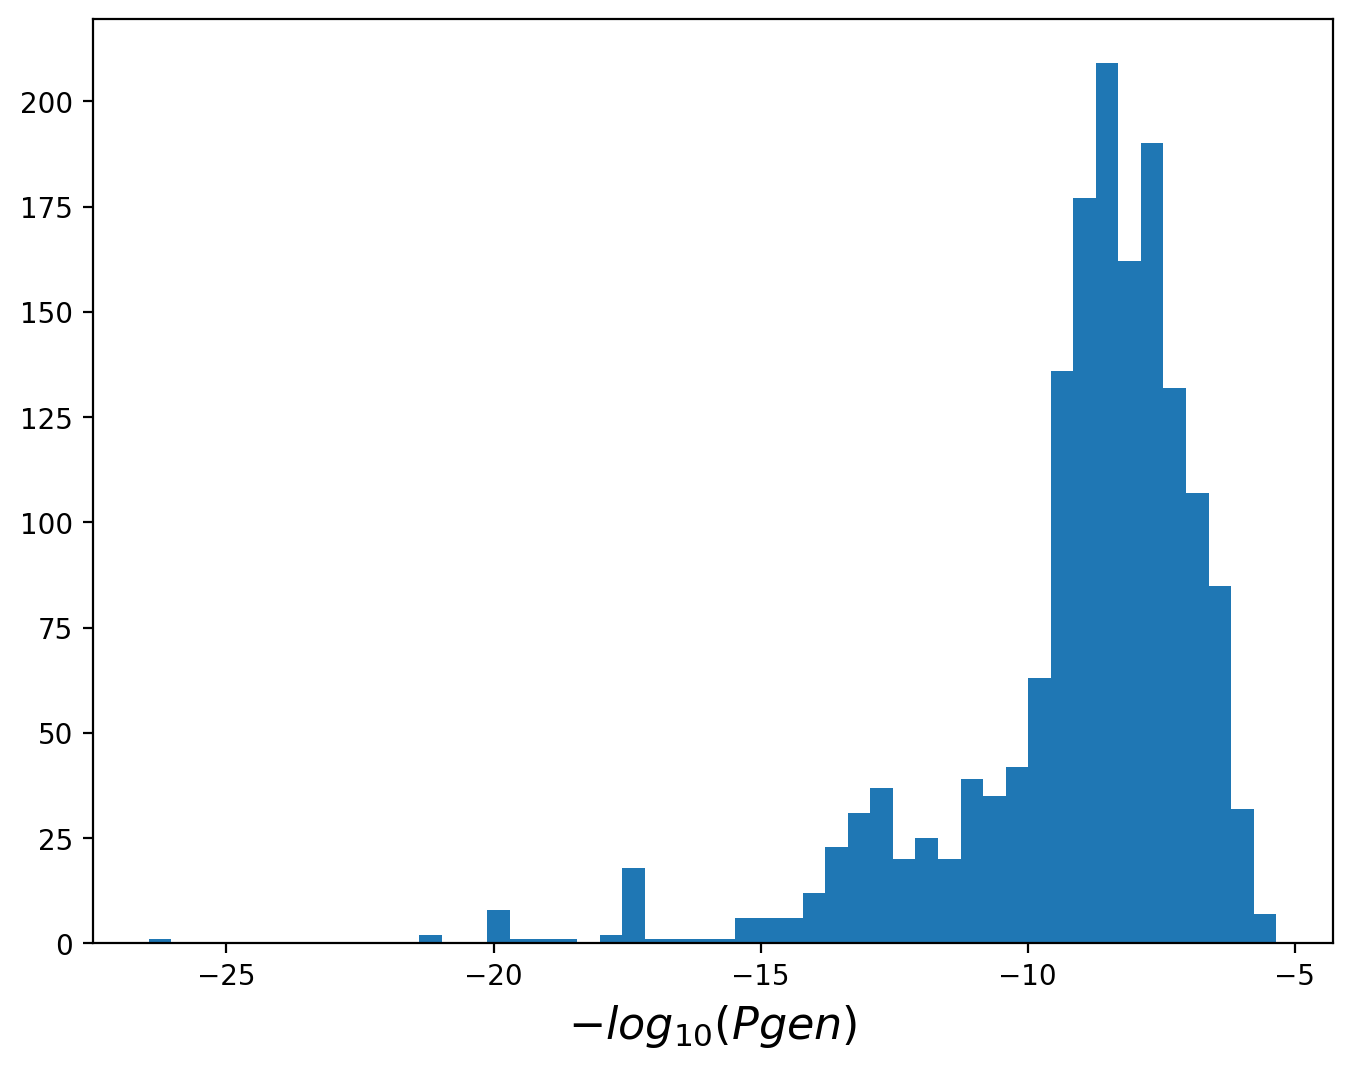

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(clones.pgen_log10, bins=50);
ax.set_xlabel('$-log_{10}(Pgen)$', size=16)